In [1]:
import sys
sys.path.insert(0, '..')
# from transformer.models import DecoderOnlyModel
from data_utils.Datasets import SerializedConcatDataset, PermSerializedConcatDataset, BinarySerializer
import pickle
import torch
import numpy as np
import os

from transformers import AutoConfig, GPT2LMHeadModel

from bertviz import model_view

import matplotlib.pyplot as plt
import networkx as nx

import pandas
from collections import Counter

import music21 as m21

In [2]:
with open('serializer.pkl', 'rb') as inp:
    binser = pickle.load(inp)

binser2 = BinarySerializer()

# define model
vocab_size = binser.vocab_size
d_model = 256
num_heads = 2
num_layers = 2
d_ff = 256
max_seq_length = binser.max_seq_length
dropout = 0.3

# dev = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dev = torch.device("cpu")

config = AutoConfig.from_pretrained(
    "gpt2",
    vocab_size=vocab_size,
    n_positions=max_seq_length,
    n_layer=num_layers,
    n_head=num_heads,
    pad_token_id=binser.padding,
    bos_token_id=binser.padding,
    eos_token_id=binser.padding,
    n_embd=d_ff
)
transformer = GPT2LMHeadModel(config).to(dev)

transformer = transformer.to(dev)

transformer = transformer.to(dev)

saved_model_path = '../saved_models/melboost_cmaj_GPT2_serialized/melboost_cmaj_GPT2_serialized.pt'
transformer.load_state_dict(torch.load(saved_model_path), strict=False)

transformer.eval()

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(30, 256)
    (wpe): Embedding(3795, 256)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-1): 2 x GPT2Block(
        (ln_1): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
  )
  (lm_head): Linear(in_features=256, out_features=30, bias=False)
)

In [25]:
# inp = torch.from_numpy( np.r_[np.arange(30), np.arange(30), np.arange(30), np.arange(30)] ).to(dev)
inp = torch.from_numpy( 2*np.ones(30).astype(int) ).to(dev)
output = transformer(inp, attention_mask=inp != 0, output_attentions=True)
a = output.attentions

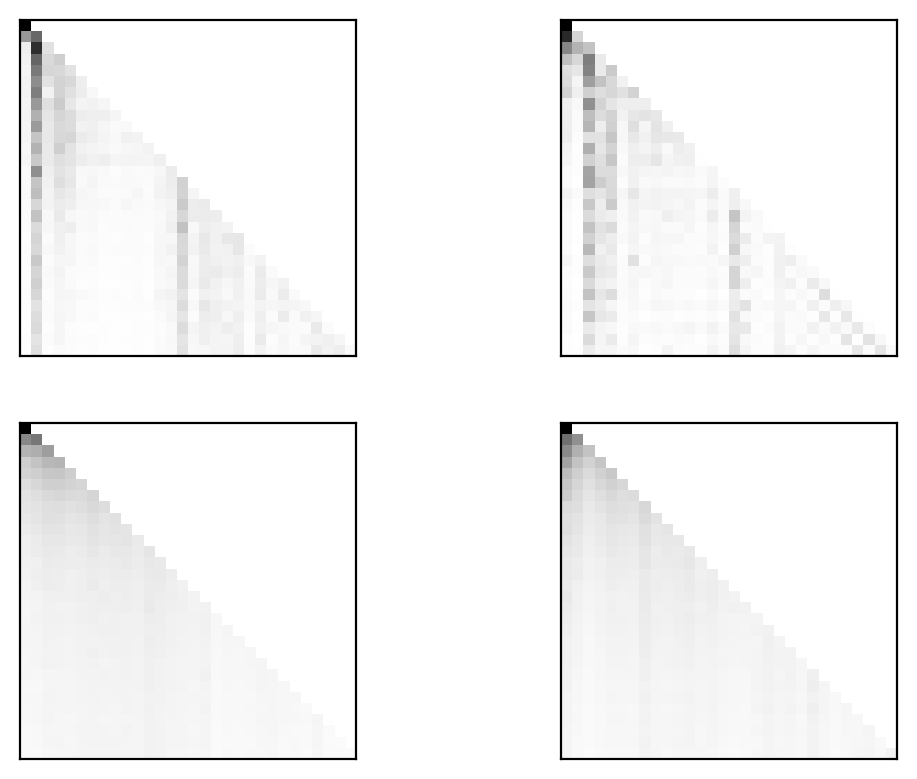

In [26]:
for l in range(2):
    for h in range(2):
        a_np = a[l][0,h,:,:].cpu().detach().numpy()
        # print( np.sum(a_np, axis=1) ) # indeed add to 1
        plt.subplot(2,2,2*l+h+1)
        # find mean per row
        m = np.mean( a_np, axis=1 )
        # plot values in each row larger than the values in each row
        # plt.imshow( a_np > m[:,None], cmap='gray_r' )
        plt.imshow( a_np , cmap='gray_r' )
        # plt.plot([a_np.shape[3], a_np.shape[3]],[0, a_np.shape[3]], 'r')
        plt.xticks([])
        plt.yticks([])